<h3>What is the sparse coding principle?</h3>
The sparse coding principal derives from the efficient coding hypothesis. The efficient coding hypothesis is based on Barlow's (1961) notion of redundancy reduction that sensory neurons would be optimized to reduce dependencies between each other during naturalistic stimulation. Olshausen and Field propose that sparse coding is a strategy towards this end. They argue it is an effective strategy because images are composed of sparse independent events (edges, lines) and optimizing for sparsity they are placing a prior that helps pick out the independence in the data. If images did not have this sparse independent structure, then their optimization would not be appropriate. 

They go even further in stating that one interpretation is that neurons would be pushed to represent independent events in the enviroment, thus giving rise to our perceptual representation of inndependent entities that give rise to an image (objects). This will be an interesting point of discussion when comparing their results to those found in Deep Learning.

<h3>How was the sparse coding model implemented?</h3>

<h4>Image Model</h4>
As a framework for their probabilistic model of images, Olshausen and Field first propose a simplified version of how images are generated.
<h4>Synthesis</h4>
They assume an image is the linear superposition of a set of basis functions:

$$I(\vec{x}) = \sum_{i} a_i \phi_i(\vec{x})$$

* $I(\vec{x})$ are the grey-scale values of our image.
* Constructed from a linear combination of basis functions $\phi_i(\vec{x})$
* By the coefficients  $a_i$


<h4>Probabilistic Framework </h4>

The authors now want to come up with $\phi_i$ such that the likelihood of a natural image being generated by them with a sparse distribution of $a_i$ is high.
Thus they want to make a distribution $P(I|\phi)$ that best matches $P^*(I)$ the presumed sparse distribution of natural images. 
$$P(I|\phi) = \int{P(I|a, \phi)P(a) da}$$
So the probability of an image in their model is the product of the prior probability of coefficients $a_i$, and the probability of an image given a set of coefficients $a_i$ and basis functions $\phi_i$.

Now lets look at how they parameterized these two terms seperately:
<h3>$P(I|a, \phi)$</h3>
The imaging model we assume is:
$$I(\vec{x}) = \sum_i a_i \phi_i(\vec{x}) + v(\vec{x})$$
Images are the sum of basis functions, and white gaussian noise.
Thus the probability of an image arising from a set of coefficients $a$ is:

$$\large P(I|a, \phi) = \frac{1}{Z_{\sigma N}}e^{\frac{|I-a\phi|^2}{2\sigma^2}}$$

* $Z$ normalizes the function to a PDF.
* $\sigma$ is our noise variance. 
* $N$ is the dimensionality of our image.

* $|I-a\phi|^2 = \sum_\vec{x} [ I(\vec{x})-\sum_i a_i \phi_i(\vec{x})]^2$ the squared distance between the image, and the image constructed by the coefficients. 

<h3>$P(a)$</h3>
In the form of this term we impose the constraint of sparse independent features. 

* Sparsity: The marginals of $P(a)$ will have high kurtosis by choosing a distribution of the form.
$$P(a_i) = \frac{1}{Z_\beta}e^{-\beta S(a_i)} $$
    * S shapes the distribution.
    * $\beta$ determines steepness
    * $Z_{\beta}$ normalizes to a PDF. 
    * $\beta = 1$ and $S(x)=log(1+x^2)$ corresponds to the Cauchy distribution, which has a peak at zero and heavy tails
   


* Independence: The features will have independence imposed upon them by choosing their joint distribution to be the product of their marginals.

$$P(a) = \prod_i P(a_i)$$

<h4>Determining fit of $P(I|\phi)$ to  $P(I)^*$</h4>
To measure the fit between the two distributions they use the Kullback-Leibler divergence:

$$KL = \int P(I)^* \log \frac{P(I)^*}{P(I|\phi)} $$ 

This measure is equal to 0 when the two distributions are the same. It measures the average amount of information per natural image as to whether it came from the distribution of natural images as opposed to the proposed model.
Since $P(I)^*$ is fixed we are just trying to maximize.
$$\log P(I|\phi)$$
 

The authors recast the problem as one of minimization:

$$E(I,a|\phi) = -\log P(I|\phi)$$

Taking the logarithm of $P(I|\phi) = P(a) P(I|a, \phi)$ both of which were cast as exponetial functions results in a cost function purely in terms of their exponents (dropping the normalizing constants):

$$E(I,a|\phi) = \sum_{\vec{x}}[I(\vec{x})- \sum_{i} a_i \phi_i(\vec{x})]^2 + \lambda \sum_i S(a_i)$$

Just for a recap we can remember that the first term comes from:
$$P(I|a, \phi) = \frac{1}{Z_{\sigma N}}e^{\frac{|I-a\phi|^2}{2\sigma^2}}$$

Which is doing its best to increase the likelihood that images were generated from this basis.

And the second term comes from:
$$P(a_i) = \frac{1}{Z_\beta}e^{-\beta S(a_i)} $$
which is what was used to include independence and sparsity. Sparsity coming from the form of S in which, relative to a squared penalty, many non-zero coefficients are more heavily penalized then a few (even if the vector of coefficients has the same magnitude). And independence from the fact that we are just adding up the unweighted sum of these costs, whereas if a couple coefficients were weighted more it would be including a prior that those two tend to have a dependence on each other, and their simultaneous activation would be penalized.

The authors essentially employ gradient descent to optimize this equation. Since they have published their paper adjustable regularization constraints such as theirs have become quite popular and more efficient. As a demonstration I employ a package from a python package called SKlearn:


In [203]:
import os, sys
import numpy as np
top_dir = os.getcwd().split('v4cnn')[0]
;sys.path.append(top_dir+ 'v4cnn/')
sys.path.append( top_dir + 'xarray');top_dir = top_dir + '/v4cnn/';
sys.path.append( top_dir + 'common/')
sys.path.append(top_dir +'/nets')
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import scipy as sp
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from PIL import Image
image = sp.misc.imread(top_dir + 'images/mtn.jpg')
image = image[::5, ::5]
image = image.astype(float)
image = image / np.max(image)
image = image - np.min(image)

([], <a list of 0 Text yticklabel objects>)

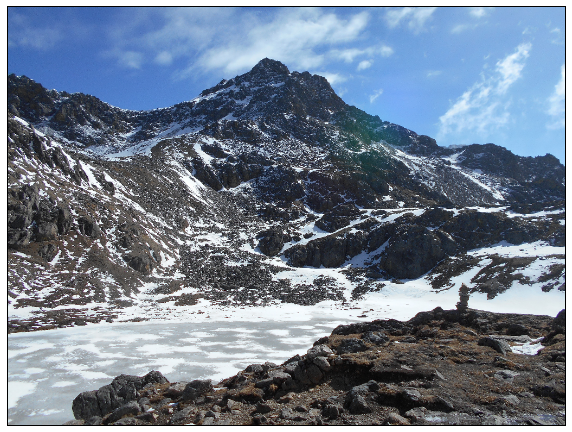

In [212]:
_=plt.figure(figsize=(10,10))
_=plt.imshow(image);plt.xticks([]);plt.yticks([])

In [221]:
patch_size = 10
data = extract_patches_2d(image, (patch_size, patch_size))
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
#ft_data = np.fft.nfft(data)
data = data.reshape(data.shape[0], np.product(data.shape[1:]))
dico = MiniBatchDictionaryLearning(n_components=10, alpha=10, n_iter=1000)
V = dico.fit(data).components_

Patch dims(780808, 10, 10, 3)


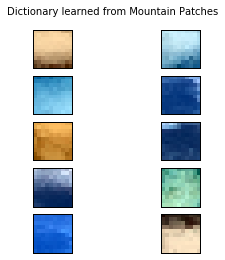

In [220]:
V = V.reshape(np.shape(V)[0], patch_size, patch_size, 3)
data = data.reshape(data.shape[0], patch_size, patch_size, 3)
print('Patch dims'+str(data.shape))
V = V - np.min(V,(1,2,3),keepdims=1)
V = V / V.max((1,2,3), keepdims=True)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V):
    plt.subplot(5, 2, i + 1)
    _=plt.imshow(comp,interpolation='nearest')
    plt.xticks(());plt.yticks(())
plt.suptitle('Dictionary learned from Mountain Patches')

We can notice a couple basic features. Many have oriented edges and tend to be a single color. These filters are not localized as in the Olshausen paper, but it was only done for a single natural image. While the Olshausen paper used grey scale photographs an interesting phenomena pops out here where hue is constant within kernels suggesting the sparse features composing at least one image tend to be low-dimensional in color space. Tentatively one could make a comparison to color responsive subunits in V1 responding along lines in color space (L-M, L+M, S-(L+M)).

<h3>What are some predictions that this principle makes for neural responsivity?</h3>
In the original work the $a_i$ would be the firing rates of neurons where each neuron represented a particular image feature $\phi_i$.
This would predict that a histogram of a neurons responses to natural images would have a peak at 0, and a heavy tail, such that they only respond occasionally but vigoruously to natural images.
One well estabilished and popular way to measure single neuron sparsity is called the activity fraction introduced by Rolls & Tovee (1995):
$$A = \frac{(\sum{r_i/n})^2}{(\sum{r_i^2/n})}$$
Where $r_i$ are the $n$ average firing rates of a neuron to a set of stimuli.

As a population sparse coding would also predict that only a small subsets of neurons would be active at any one time. A common metric of this population sparsity is simply changin the $r_i$ in the equation above from responses of one neuron to many stimuli instead to the responses of many neurons to one stimuli.

The sparse coding principle would predict both of these metrics increase along the ventral stream.

<h3>What are some predictions that this principle makes for connectivity? </h3>

Simoncelli and Olshausen (2001) nicely discuss how filters such as the Gabors that are derived above tend to still be highly dependent on each other in terms of their variance over images. Below I make a small demonstration of this kind of dependence. They work out why certain types of inhibitory connectivity would reduce this dependency, this in turn increases population sparsity.

([], <a list of 0 Text yticklabel objects>)

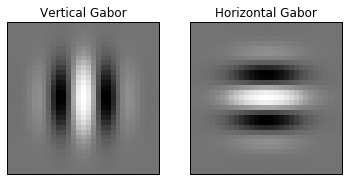

In [222]:
import numpy as np
from scipy import misc
from scipy import ndimage
from PIL import Image
image = misc.imread(top_dir + 'images/mtn.jpg')
image = image[::5, ::5]
image = np.sum(image,2)
image = image.astype(float)
image -=  image.mean()

from skimage.filters import gabor_kernel
kernel = np.real(gabor_kernel(0.1, theta=0, sigma_x=5, sigma_y=5))
plt.subplot(121)
plt.imshow(kernel,interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])
plt.title('Vertical Gabor')
plt.subplot(122)
plt.title('Horizontal Gabor')
plt.imshow(kernel.T,interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])

Here we have two gabor kernel, similar to those seen in Olshausen Field paper, now lets try running these across a natural image.

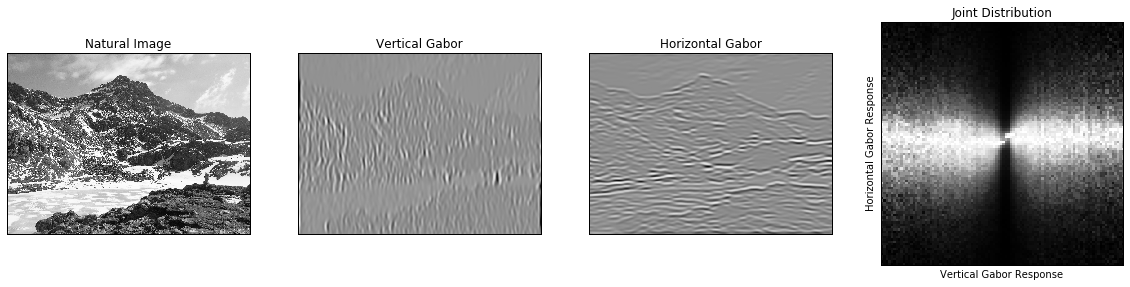

In [200]:
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(image, interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])
plt.title('Natural Image')
plt.subplot(142)
kernel = np.real(gabor_kernel(0.05, theta=0, sigma_x=10, sigma_y=10))
filt_im1 = ndimage.convolve(image, kernel, mode='wrap')
plt.imshow(filt_im1/np.max(filt_im1), interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])
plt.title('Vertical Gabor')

plt.subplot(143)
kernel = np.real(gabor_kernel(0.05, theta=np.pi/2., sigma_x=10, sigma_y=10))
filt_im2 = ndimage.convolve(image, kernel, mode='wrap')
plt.imshow(filt_im2/np.max(filt_im2), interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])
plt.title('Horizontal Gabor')

plt.subplot(144)
steps = 1
filt_im1 /= np.abs(filt_im1).max()
filt_im2 /= np.abs(filt_im2).max()
H, x, y = np.histogram2d(filt_im1.ravel(), filt_im2.ravel(), range=[[-0.3,0.3],[-0.3,0.3]], bins=100)
H = H/np.max(H,0, keepdims=True)
plt.imshow(np.flipud(H), interpolation='nearest',cmap='Greys_r');plt.xticks([]);plt.yticks([])
plt.title('Joint Distribution')
plt.xlabel('Vertical Gabor Response')
plt.ylabel('Horizontal Gabor Response')

I've scaled the conditionals along the y axis, so that one can see whats going on. The conditionals are getting less and less sparse, and this change in shape of the distributions denotes a strong non-linear dependence between the two Gabor responses. 

The authors worked out that one way to reduce this dependency is normalize by a weighted sum of squared responses from a pool of filters, where the weights would be optimized to reduce this dependency. 

Intuitively weights would increase between filters, which are strongly dependent in this manner. On a population level this inhibition between filters that are statistically dependent would inhibit simultaneous activations in natural scenes and produce an increase in population sparsity.

<h3>What is the biological evidence for and against these predictions? </h3>

One basic constraint on the nervous system is energy, which partially motivates sparse codes. With a lower average firing rate, there will be less expenditure of energy. Lennie in 2003, made a simple calculation of how much energy a single neuron expends depending on spiking rate, and then comparing it to the amount of energy the brain uses determined that by necessity average firing rate should be low (1 Hz) and only 1% of neurons could be substantially active at any one time.

In terms of experimental evidence during exposure to natural imagery primary cortex has been found to be quite sparse (Weliky, 2003). The authors found both sparsity at a single neuron level and population level to be quite high, especially compared to the case when preferred stimuli are made to drive cells (i.e. gratings).

An anatomical feature of the visual system that has been considered consistent with the sparse coding hypothesis is that there is a high expansion rate of inputs. So from LGN to V1 there is a 25:1 ratio of axons leaving V1 then LGN. This high expansion rate would be consistent with an over complete code which would allow a smaller fractional subset of active neurons to represent a given scene.

There is an interesting divergence population sparseness and single unit sparseness as we move higher in the ventral stream. Take for example the fusiform face area, which has neurons that primarily respond to faces, if one recorded neurons responses to many natural images faces would only occasionally appear and thus these neurons would appear sparse. Yet neurons in the FFA and its homolog in primate have been shown to a have a rich population code for faces (Freiwald et al. 200). In V4 evidence points to populations of neurons representing individual features of a single object (Pasupathy et al., 2002). Thus within the space of all images neurons might appear sparse, perhaps necessarily so for energetic demands, but once the relevant stimuli has been hit upon a more fault tolerant distributed population code is used.


<h3>What if anything is the relationship between this principle and assumptions or methods in “deep” learning networks for vision?</h3>

The intuitive motivation offered in Olshausen and Fields original paper for sparse coding invoked the structure of visual objects: 
'The reason for conjecturing that sparseness is an appropriate prior for the $a_i$ is based on the intuition that natural images may generally be described in terms of a small number of structural primitives--for example, edges, lines, or other elementary features (Field, 1994).'

One way to judge a relationship between sparsity and object recognition deep neural nets is examined whether after optimizations under either objective do similar features appear. It has been qualitatively observed that the first layer filters of many deep learning networks do in fact recapitulate the types of gabors seen for sparse coding objectives. My own research has found them to as a population tile frequency and orientation in a similar manner to those derived by sparse priors.

In my own research measuring single unit sparsity across layers of AlexNet it is actually the 1st and last layer that are the sparsest. The first is sparse because it actually forms Gabor like filters, and Gabor filters have been shown to have sparse responses to natural images. Sparsity does tend to jump up after each rectification in the network but then when those responses are recombined at the next level the distribution becomes broad again. The increase in sparsity in the final layer is strongly enforced by the objective as these units are trained to be literal 'grandmother neurons' only responding to 1 of 1000 categories. This is unlike the first layer which was not explicitly optimized to respond to a small subset of images, thus sparse responses to images in early responses could very well be a good strategy for representing objects as intuitively argued by Fields (1994), the fact that this level of sparsity is not maintained though would suggest that sparsity isn't the whole story.

One feature of these networks that could be considered a sparse prior is their connectivity. Convolutional units only have access to a small fraction of the image thus spatially are quite sparse in their responses. This spatial connectivity or receptive field size increases gradually with layer. In addition in relation to previous discussion of anatomical evidence of sparse codes there is a high expansion ratio in these nets, with far more units then input pixels. 


References

Bell, Anthony J., and Terrence J. Sejnowski. “The ‘independent Components’ of Natural Scenes Are Edge Filters.” Vision Research 37, no. 23 (December 1997): 3327–38. doi:10.1016/S0042-6989(97)00121-1.

Freiwald WA, Tsao DY, Tootell RBH, Livingstone MS: Single-unit recording in an FMRI-identified macaque face patch. II. Coding along multiple feature axes. Soc Neurosci 2005:362.6.

Lennie, Peter. “The Cost of Cortical Computation.” Current Biology 13, no. 6 (March 18, 2003): 493–97. doi:10.1016/S0960-9822(03)00135-0.

Olshausen, Bruno A., and David J. Field. “Emergence of Simple-Cell Receptive Field Properties by Learning a Sparse Code for Natural Images.” Nature 381, no. 6583 (June 13, 1996): 607–9. doi:10.1038/381607a0.

Olshausen, Bruno A, and David J Field. “Sparse Coding of Sensory Inputs.” Current Opinion in Neurobiology 14, no. 4 (August 2004): 481–87. doi:10.1016/j.conb.2004.07.007.

Olshausen, Bruno A., and David J. Field. “Sparse Coding with an Overcomplete Basis Set: A Strategy Employed by V1?” Vision Research 37, no. 23 (December 1997): 3311–25. doi:10.1016/S0042-6989(97)00169-7.

Schwartz, Odelia, and Eero P. Simoncelli. “Natural Signal Statistics and Sensory Gain Control.” Nature Neuroscience 4, no. 8 (2001): 819–25. doi:10.1038/90526.

Pasupathy A, Connor CE: Population coding of shape in area V4. Nat Neurosci 2002, 5:1332-1338.

Simoncelli, Eero P. “Vision and the Statistics of the Visual Environment.” Current Opinion in Neurobiology 13, no. 2 (April 2003): 144–49. doi:10.1016/S0959-4388(03)00047-3.

Simoncelli, Eero P., and Bruno A. Olshausen. “Natural Image Statistics and Neural Representation.” Annual Review of Neuroscience 24, no. 1 (2001): 1193–1216. doi:10.1146/annurev.neuro.24.1.1193.

Weliky, Michael, József Fiser, Ruskin H. Hunt, and David N. Wagner. “Coding of Natural Scenes in Primary Visual Cortex.” Neuron 37, no. 4 (February 20, 2003): 703–18. doi:10.1016/S0896-6273(03)00022-9.
